In [29]:
pip install mlflow==2.13.2 sagemaker-mlflow==0.1.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 66.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [74]:
import os
import boto3
import mlflow
import pickle

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Settings

In [33]:
base_dir = '/home/sagemaker-user/sagemaker/02_wine_mlflow_e2e' # The base dir on jupyer lab
bucket_name = 'sagemaker-bucket-ds' # Name of the bucket where data and model are stored
project_path_s3 = 'wine' # path to the folder with the project
experiment_name = "wine-experiments" # Name of the experiment
mlflow_arn = "arn:aws:sagemaker:eu-west-1:211125740051:mlflow-tracking-server/Sample-server"

#### Create paths

In [75]:
data_s3_path  = os.path.join('s3://', bucket_name, project_path_s3, 'data') 
bi_s3_path = os.path.join('s3://', bucket_name, project_path_s3, 'batch_inference_input') 

train_s3_path = os.path.join(data_s3_path, 'train.csv')
test_s3_path = os.path.join(data_s3_path, 'test.csv')
infer_s3_path = os.path.join(bi_s3_path, 'infer.csv')
columns_s3_path = os.path.join(data_s3_path, 'column_names.csv')

data_local_path = os.path.join(base_dir, 'data') # Folder with data
inference_local_path = os.path.join(data_local_path, 'inference_normal.csv') # Path to CSV file with train
charts_local_path = os.path.join(base_dir, "CHARTS") # Folder with charts

#### Basic objects

In [4]:
s3 = boto3.client('s3')

#### Read data from S3

In [59]:
# Helper function to read CSV file from S3
def read_csv_from_s3(s3_path):
    bucket, key = s3_path.replace("s3://", "").split("/", 1)
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(obj['Body'], header=None)

# Load column names
column_names_df = read_csv_from_s3(columns_s3_path)
column_names = column_names_df.iloc[0].tolist()

# Load data without headers
df_train = read_csv_from_s3(train_s3_path)
df_train.columns = column_names

df_test = read_csv_from_s3(test_s3_path)
df_test.columns = column_names

df_infer = read_csv_from_s3(infer_s3_path)
df_infer.columns = column_names[1:]

# Display the dataframe
print(df_train.head())
print("\n\n\n\n\n")
print(df_test.head())
print("\n\n\n\n\n")
print(df_infer.head())

   target  alcohol_12-13  alcohol_13-14  alcohol_>14  ash_2-2.5  ash_>2.5  \
0       0              0              1            0          0         1   
1       0              0              1            0          1         0   
2       1              1              0            0          1         0   
3       1              0              0            0          1         0   
4       1              0              0            0          0         0   

   color_intensity_3-5  color_intensity_5-7  color_intensity_>7  
0                    0                    1                   0  
1                    0                    1                   0  
2                    0                    0                   0  
3                    1                    0                   0  
4                    0                    0                   0  






   target  alcohol_12-13  alcohol_13-14  alcohol_>14  ash_2-2.5  ash_>2.5  \
0       1              1              0            0      

#### Configure mlflow

In [36]:
mlflow.set_tracking_uri(mlflow_arn)
mlflow.set_experiment(experiment_name)

2024/06/26 08:10:24 INFO mlflow.tracking.fluent: Experiment with name 'wine-experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://sagemaker-bucket-ds/ML_FLOW/1', creation_time=1719389424478, experiment_id='1', last_update_time=1719389424478, lifecycle_stage='active', name='wine-experiments', tags={}>

#### Train the model

In [38]:
# Prepare the feature matrix X and target variable y for training data
X_train = df_train.iloc[:, 1:]
y_train = df_train.iloc[:, 0]

# Prepare the feature matrix X and target variable y for test data
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, 0]

# Fit the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Display the coefficients and intercept
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + df_train.columns[1:].tolist(),
    'Coefficient': [logistic_model.intercept_[0]] + list(logistic_model.coef_[0])
})

# Predict probabilities for training and test datasets
y_train_pred_proba = logistic_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Calculate AUC for training and test datasets
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

# Display the AUC scores
print(f'Training AUC: {auc_train}')
print(f'Test AUC: {auc_test}')

# Display the coefficients
coefficients

Training AUC: 0.9925213675213674
Test AUC: 0.9108695652173914


,Feature,Coefficient
0,Intercept,1.996788
1,alcohol_12-13,1.476777
2,alcohol_13-14,-2.243006
3,alcohol_>14,-1.894757
4,ash_2-2.5,-0.341101
5,ash_>2.5,-0.639466
6,color_intensity_3-5,-0.287002
7,color_intensity_5-7,-1.750937
8,color_intensity_>7,-1.018866


#### CREATE PLOT

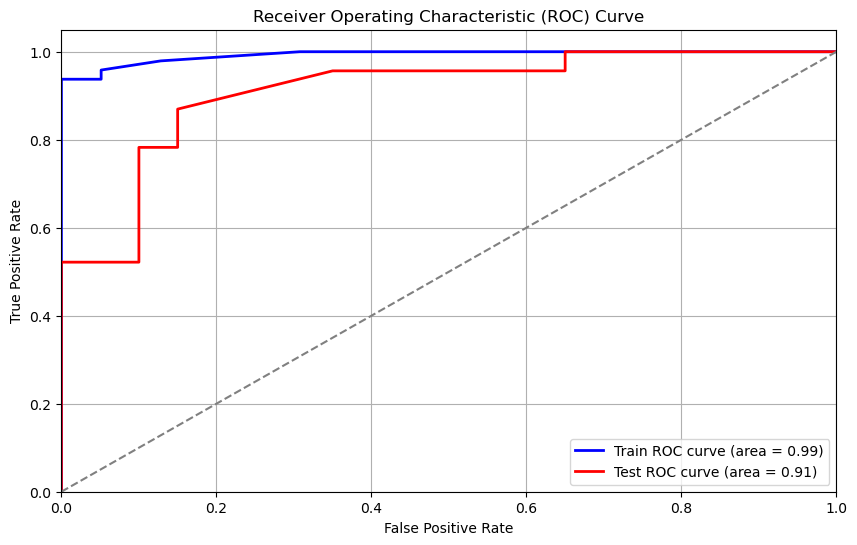

In [54]:
os.makedirs(charts_local_path, exist_ok=True) # Create charts folder

# Predict probabilities
y_train_pred_proba = logistic_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

plt.savefig(os.path.join(charts_local_path, "auc_roc_curve.png"))

#### Log the model

In [55]:
# Start an MLflow run and log parameters, metrics, and model artifacts
# Define the model hyperparameters
params = {"solver": "lbfgs", "max_iter": 1000, "multi_class": "auto", "random_state": 8888}
with mlflow.start_run():
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("AUC_train", auc_train)
    mlflow.log_metric("AUC_test", auc_test)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for wine data")

    # Infer the model signature
    signature = infer_signature(X_train, logistic_model.predict(X_train))

    mlflow.log_artifact(os.path.join(charts_local_path, "auc_roc_curve.png"))
    
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=logistic_model,
        artifact_path="wine_model",
        signature=signature,
        input_example=X_train
    )

/opt/conda/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or

You can view experiment runs in MLFlow
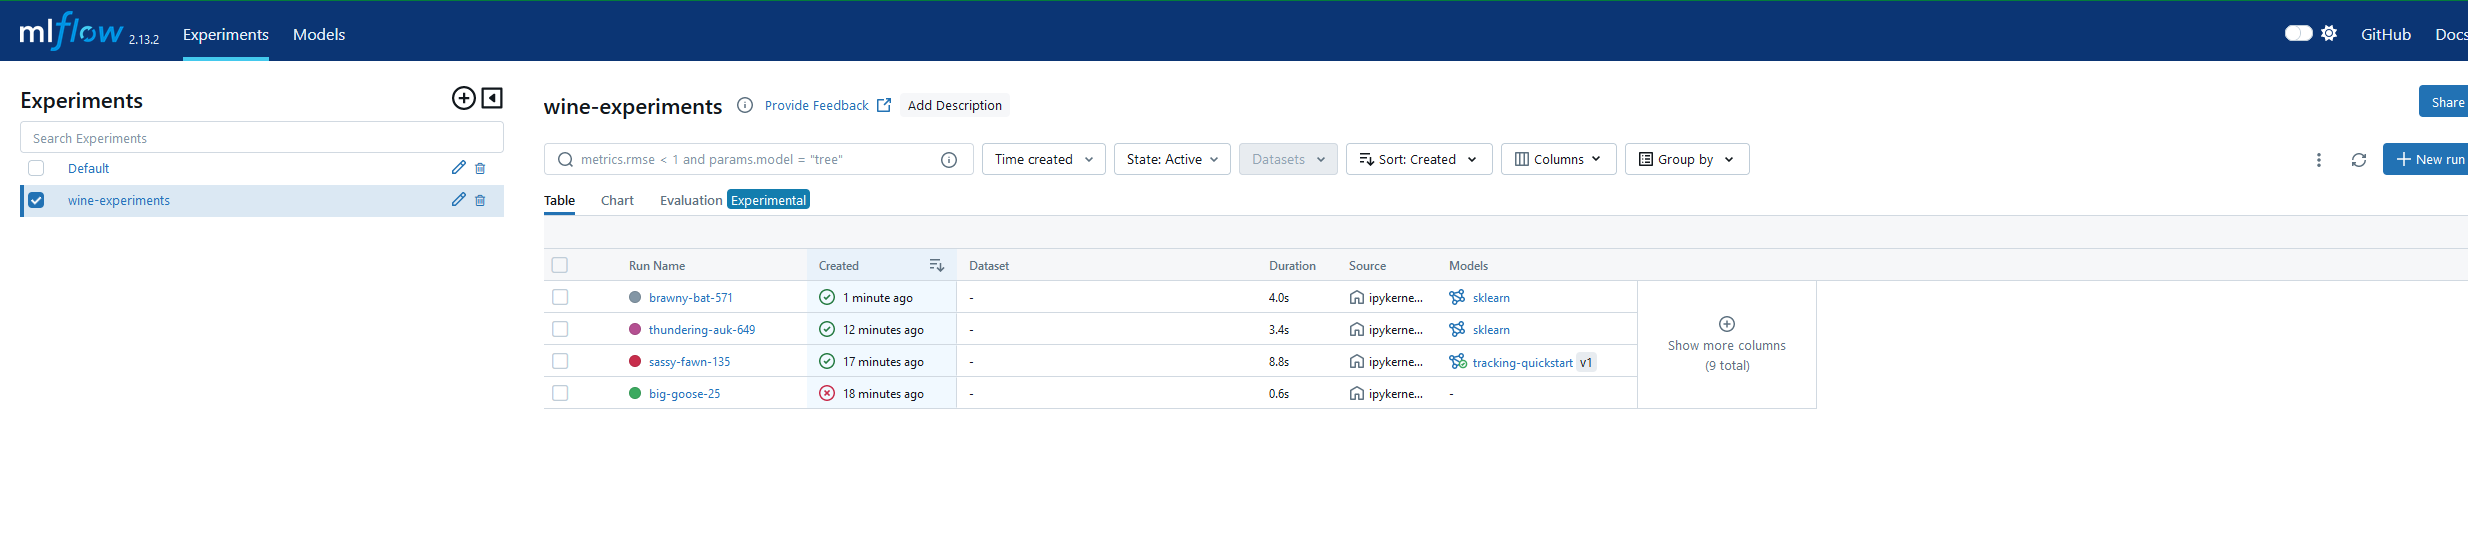

#### Save inference results

In [71]:
# Make predictions on df_infer
predictions = logistic_model.predict_proba(df_infer)[:,1]
np.savetxt(inference_local_path, predictions, delimiter=',', fmt='%.6f')
s3_key = os.path.join(project_path_s3, 'batch_inference_output', 'inference_normal.csv') 

# Upload the file
s3.upload_file(inference_local_path, bucket_name, s3_key)

#### Save model

In [73]:
# Save the model to a local file
os.makedirs(os.path.join(base_dir,'model'), exist_ok=True) # Create data folder
local_model_path = os.path.join(base_dir,'model', 'lr_normal.pkl')

with open(local_model_path, 'wb') as f:
    pickle.dump(logistic_model, f)
    
# Upload the CSV file to S3
key_model = os.path.join(project_path_s3, 'model', 'lr_normal.pkl') 
s3.upload_file(local_model_path, bucket_name, key_model)